In [2]:
import os
import random
import sys
import time

import numpy as np
import pandas as pd
import spotpy

sys.path.append("..")

from evaluation_metrics import nse_loss
from hydrological_models import HBV as hydrological_model
from modelcalibration import calibrate_basins
from modelcalibration_caravan import ModelCalibrationCaravan as model_calibration
from modelcalibration_caravan import check_basins_caravan as check_basins
from optimization_methods import dream as optimization_method
from spotpy.likelihoods import gaussianLikelihoodMeasErrorOut as obj_func

In [3]:
# Initialize information
path_entities = '/pfs/data6/home/ka/ka_iwu/ka_as2023/Hy2DL_Caravan/data/basin_id/testde_5.txt'
path_data = '/pfs/data6/home/ka/ka_iwu/ka_as2023/Hy2DL_Caravan/data/caravan'
input_variables = ['camelsde_DEA11130','evap', 'temperature_2m_mean']
target_variables = ["streamflow"]
training_period = ["1990-01-01", "2010-12-31"]
testing_period = ["2010-01-01", "2020-12-31"]
batch_size = 15
warmup_period = 365
random_seed = 700

# Save results
path_output = "../results/conceptual_models_CARAVAN_R2_lstm/"

# use when one select the best parameters, depends on the loss function one wants.
maximize = True  # True for gaussian_likelihood, False of rmse

# set random seed
random.seed(random_seed)
np.random.seed(random_seed)

# Read information
basins_id = np.loadtxt(path_entities, dtype="str").tolist()
selected_basins_id = check_basins(
    path_data=path_data,
    basins_id=basins_id,
    target_variables=target_variables,
    training_period=training_period,
    testing_period=testing_period,
)

# Check if the path where one will store the results exists. In case it does not, it creates such path.
if not os.path.exists(path_output):
    # Create the folder
    os.makedirs(path_output)
    print(f"Folder '{path_output}' created successfully.")
else:
    print(f"Folder '{path_output}' already exists.")

Folder '../results/conceptual_models_CARAVAN_R2_lstm/' created successfully.


In [4]:
# Process the basins in batches (avoid memory issues)
batches = [selected_basins_id[i : i + batch_size] for i in range(0, len(selected_basins_id), batch_size)]
batches

[['testde_4',
  'testde_4',
  'testde_4',
  'testde_4',
  'testde_4',
  'testde_4',
  'testde_4',
  'testde_4']]

In [5]:
# Manual changes to ensure I only have one batch for my single basin
# Caution - this is a workaround I do for running for single basins - AMJ 09.10.2024
batches = [batches[0][:1]]
batches

[['testde_4']]

In [6]:
dfs = []
start_time = time.time()
for basin_batch in batches:
    training_object = {}
    testing_object = {}

    for basin in basin_batch:
        training_object[basin] = model_calibration(
            model=hydrological_model(),
            path_data=path_data,
            basin_id=basin,
            input_variables=input_variables,
            target_variables=target_variables,
            time_period=training_period,
            obj_func=obj_func,
            warmup_period=warmup_period,
        )

        testing_object[basin] = model_calibration(
            model=hydrological_model(),
            path_data=path_data,
            basin_id=basin,
            input_variables=input_variables,
            target_variables=target_variables,
            time_period=testing_period,
            obj_func=obj_func,
            warmup_period=warmup_period,
        )

    # Run the calibration of the different basins in parallel --------------------------------------------------
    optimizer = optimization_method(random_state=random_seed)
    calibrate_basins(
        training_object=training_object,
        optimization_method=optimizer,
        basins=basin_batch,
        path_output=path_output,
        random_seed=random_seed,
    )

    # Process and summarize the results -------------------------------------------------------------------------
    hyd_model = hydrological_model()
    optimizer = optimization_method()
    df_calibration = pd.DataFrame(
        index=range(len(basin_batch)),
        columns=["basin_id", "NSE_training"] + list(hyd_model.parameter_ranges) + ["NSE_testing"],
    )

    for i, basin in enumerate(basin_batch):
        # extract calibrated parameters
        file_name = path_output + hyd_model.name + "_" + optimizer.name + "_" + str(basin)
        results = spotpy.analyser.load_csv_results(file_name)
        calibrated_param = spotpy.analyser.get_best_parameterset(results, maximize=maximize)[0]

        # Training period ------------------------------------------
        q_sim = training_object[basin].simulation(calibrated_param)
        q_obs = training_object[basin].evaluation()

        # Convert to DataFrame and save - Single Basin
        df_train = pd.DataFrame({
            'q_sim': q_sim,
            'q_obs': q_obs
        })

        df_train.to_csv(f'{path_output}{hyd_model.name}_{optimizer.name}_train_{basin}.csv', index=False)

        # Calculate loss
        evaluation = q_obs[warmup_period:][training_object[basin].data_split[warmup_period:]]
        simulation = q_sim[warmup_period:][training_object[basin].data_split[warmup_period:]]
        mask_nans = ~np.isnan(evaluation)
        NSE_training = nse_loss(
            evaluation=evaluation[mask_nans].flatten(), simulation=simulation[mask_nans].flatten()
        )

        # Testing period ------------------------------------------
        q_sim = testing_object[basin].simulation(calibrated_param)
        q_obs = testing_object[basin].evaluation()

        # Convert to DataFrame and save - Single Basin
        df_test = pd.DataFrame({
            'q_sim': q_sim,
            'q_obs': q_obs
        })

        df_test.to_csv(f'{path_output}{hyd_model.name}_{optimizer.name}_test_{basin}.csv', index=False)
        
        # Calculate loss
        evaluation = q_obs[warmup_period:][testing_object[basin].data_split[warmup_period:]]
        simulation = q_sim[warmup_period:][testing_object[basin].data_split[warmup_period:]]

        # Mask NaNs in both evaluation and simulation
        mask_nans = ~np.isnan(evaluation) & ~np.isnan(simulation)

        # Apply the mask to both evaluation and simulation
        evaluation_masked = evaluation[mask_nans].flatten()
        simulation_masked = simulation[mask_nans].flatten()

        # Calculate the NSE loss
        NSE_testing = nse_loss(evaluation=evaluation_masked, simulation=simulation_masked)

        # Save the result of the basin
        df_calibration.loc[i] = [basin, NSE_training] + list(calibrated_param) + [NSE_testing]

    # Dataframe of the batch
    dfs.append(df_calibration)

 # Save the results
combined_df = pd.concat(dfs)
combined_df.to_csv(path_output + hyd_model.name + "_" + optimizer.name + "_summary.csv", index=False)
# Calculate and print the calibration time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total calibration time: {int(elapsed_time)} seconds")

Initializing the  DiffeRential Evolution Adaptive Metropolis (DREAM) algorithm  with  5000  repetitions
The objective function will be maximized
Starting the DREAM algotrithm with 5000 repetitions...
Initialize  7  chain(s)...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file '../results/conceptual_models_CARAVAN_R2_lstm/HBV_dream_testde_4.csv' created.
Beginn of Random Walk


/home/ka/ka_iwu/ka_as2023/.local/lib/python3.11/site-packages/spotpy/algorithms/dream.py:238: RuntimeWarning: invalid value encountered in sqrt
  R_stat = np.sqrt(


37 of 5000, maximal objective function=-25350.9, time remaining: 00:04:25
Acceptance rates [%] =20. 20. 20. 40. 40. 40. 20.
Convergence rates = 6.0242 13.7606  5.639   2.8681  7.1096  4.896   5.7788  7.7832  3.7678
  6.0484  5.1416  4.3927  9.9219  2.7933


/home/ka/ka_iwu/ka_as2023/.local/lib/python3.11/site-packages/spotpy/algorithms/dream.py:384: RuntimeWarning: overflow encountered in exp
  logMetropHastRatio = np.exp(


76 of 5000, maximal objective function=-24756.9, time remaining: 00:04:20
Acceptance rates [%] =27.27 18.18 18.18 18.18 27.27 36.36 45.45
Convergence rates =2.5671 4.3208 1.7045 2.1855 5.0999 2.9387 1.9232 4.2235 2.0891 2.4782
 2.5319 2.7902 2.6028 3.0617
115 of 5000, maximal objective function=-24756.9, time remaining: 00:04:17
Acceptance rates [%] =23.53 11.76 17.65 11.76 29.41 41.18 35.29
Convergence rates =4.6199 6.6366 2.1015 2.3631 3.2286 5.2077 2.6066 3.3486 2.3684 2.9181
 3.0187 2.5829 4.0657 6.5302
152 of 5000, maximal objective function=-24756.9, time remaining: 00:04:17
Acceptance rates [%] =21.74  8.7  17.39 13.04 26.09 30.43 30.43
Convergence rates =5.8398 5.8708 4.0101 4.1979 2.7606 4.2702 4.1477 3.2308 3.7337 2.3566
 3.5015 3.0065 5.5689 2.7153
191 of 5000, maximal objective function=-24756.9, time remaining: 00:04:15
Acceptance rates [%] =17.24  6.9  20.69 10.34 20.69 24.14 27.59
Convergence rates =3.1538 4.4808 4.9273 5.2439 2.6023 4.1409 3.7134 3.7166 4.8067 3.1679
 4

/pfs/data6/home/ka/ka_iwu/ka_as2023/Hy2DL_Caravan/Hy2DL/conceptual_models/hydrological_models.py:469: RuntimeWarning: invalid value encountered in divide
  uh = gamma_pdf / np.sum(gamma_pdf)


Acceptance rates [%] =14.63  4.88 14.63  7.32 14.63 17.07 24.39
Convergence rates = 3.3343  5.2942  4.0507  4.193   3.9855 29.0465  3.656  17.6483  4.5454
 35.6986  8.3825  4.9285  6.1939 20.2583
307 of 5000, maximal objective function=-24756.9, time remaining: 00:04:08
Acceptance rates [%] =14.89  4.26 14.89  6.38 12.77 14.89 21.28
Convergence rates = 4.2826  6.3928  3.8544  4.6481  3.9041 28.0321  4.4151 15.7356  4.4786
 11.1567  7.8998  4.2407  7.7805 18.2221
344 of 5000, maximal objective function=-24756.9, time remaining: 00:04:07
Acceptance rates [%] =13.21  7.55 13.21  5.66 11.32 15.09 18.87
Convergence rates = 6.3234  9.8249  3.7502  4.4405  4.2401 19.2395  5.2637  7.7054  3.7046
  5.8861  5.6139  4.2745  5.6052 12.789 
382 of 5000, maximal objective function=-24597.7, time remaining: 00:04:05
420 of 5000, maximal objective function=-24597.7, time remaining: 00:04:03
Acceptance rates [%] =11.86  6.78 13.56  6.78 10.17 13.56 18.64
Convergence rates = 5.155   4.4301  4.0915  5.14

/home/ka/ka_iwu/ka_as2023/.local/lib/python3.11/site-packages/spotpy/algorithms/dream.py:111: RuntimeWarning: divide by zero encountered in scalar divide
  gamma = 2.38 / np.sqrt(2 * nchain_pairs * d_star)  # /self.gammalevel


Acceptance rates [%] = 9.09  6.49 11.69  6.49  9.09 11.69 18.18
Convergence rates =3.0844 3.2616 6.3297 4.8966 5.5324 5.6372 4.9129 2.7028 2.4642 3.0333
 2.9325 6.6342 3.8497 7.8467
573 of 5000, maximal objective function=-24491.6, time remaining: 00:03:55
Acceptance rates [%] = 9.64  7.23 14.46  6.02  8.43 10.84 16.87
Convergence rates =2.6548 2.9513 5.349  3.2304 3.1883 3.993  4.7402 2.2997 2.3455 2.7687
 2.2973 4.6919 3.8227 5.4717
612 of 5000, maximal objective function=-24285, time remaining: 00:03:53
Acceptance rates [%] = 8.99  6.74 13.48  5.62  7.87 11.24 15.73
Convergence rates =2.5706 2.9121 4.2965 2.9039 2.3882 3.7051 4.6812 2.2567 2.1076 2.5546
 2.0099 3.4779 4.1553 5.0372
651 of 5000, maximal objective function=-24006.1, time remaining: 00:03:50
Acceptance rates [%] = 9.47  7.37 13.68  6.32  7.37 11.58 14.74
Convergence rates =2.544  2.8267 3.8535 2.7858 2.1633 3.4072 4.7968 2.2485 1.9843 2.5565
 1.7158 3.0406 4.4345 4.3159
690 of 5000, maximal objective function=-24006.1,

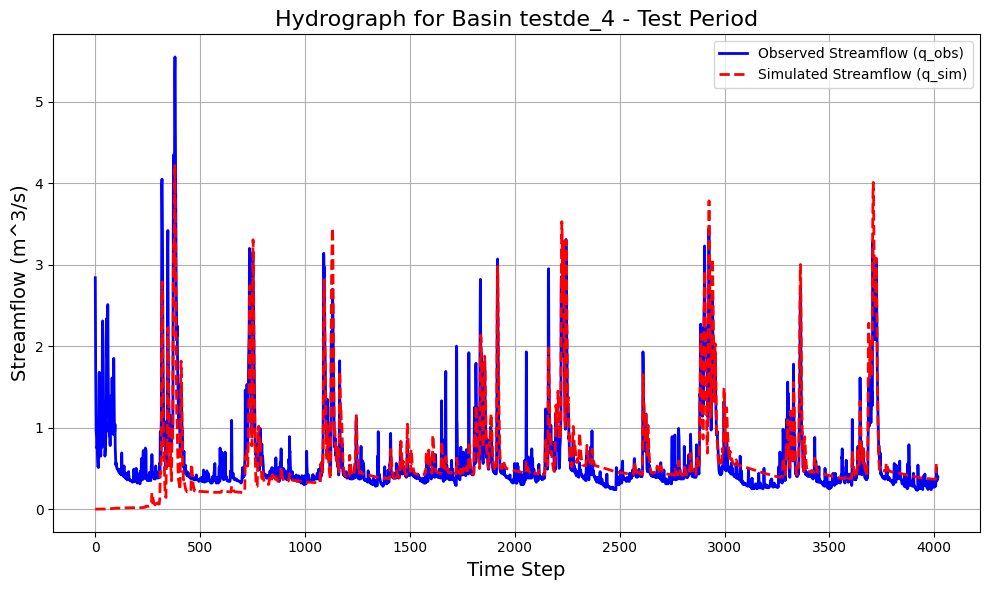

In [7]:
import matplotlib.pyplot as plt

# Read the df_test CSV file
df_test = pd.read_csv(f'{path_output}{hyd_model.name}_{optimizer.name}_test_{basin}.csv')

# Assuming the file has 'q_sim' and 'q_obs' columns
q_sim = df_test['q_sim']
q_obs = df_test['q_obs']

# Create a plot for the hydrograph
plt.figure(figsize=(10, 6))

# Plot observed streamflow
plt.plot(q_obs, label='Observed Streamflow (q_obs)', color='blue', linewidth=2)

# Plot simulated streamflow
plt.plot(q_sim, label='Simulated Streamflow (q_sim)', color='red', linestyle='--', linewidth=2)

# Adding labels and title
plt.title(f"Hydrograph for Basin {basin} - Test Period", fontsize=16)
plt.xlabel("Time Step", fontsize=14)  # Assuming each row is a time step
plt.ylabel("Streamflow (m^3/s)", fontsize=14)
plt.grid(True)

# Show the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

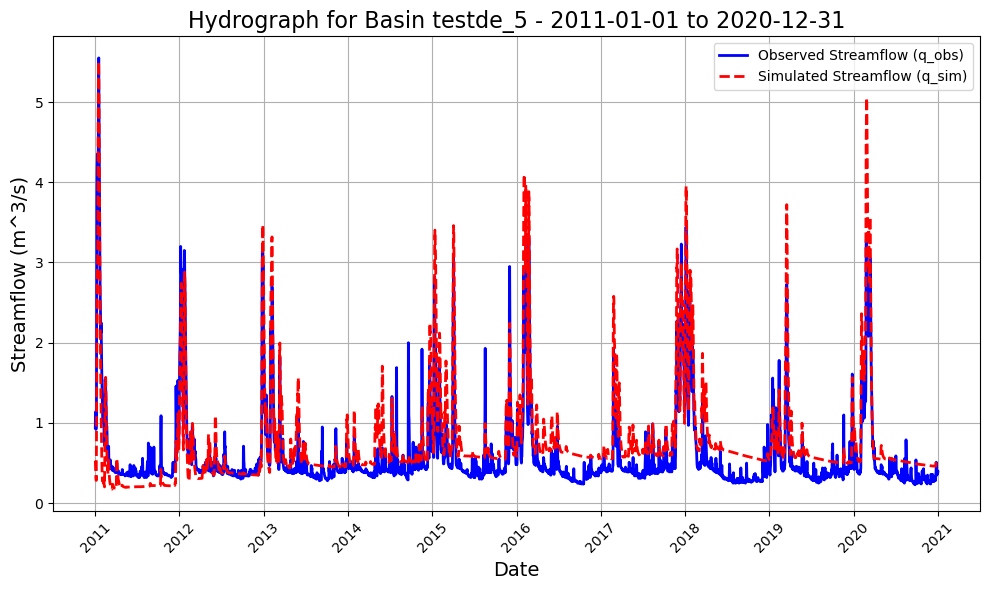

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the testing period
start_date = "2010-01-01"
end_date = "2020-12-31"


# Read the df_test CSV file
df_test = pd.read_csv(f'{path_output}{hyd_model.name}_{optimizer.name}_test_{basin}.csv')

# Assuming the file has 'q_sim' and 'q_obs' columns
q_sim = df_test['q_sim']
q_obs = df_test['q_obs']

# Create a date range based on the testing period (adjust the frequency if needed)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Ensure the date range matches the length of your data
if len(date_range) != len(q_sim):
    raise ValueError(f"The date range length {len(date_range)} does not match the data length {len(q_sim)}")

# Define the custom time window
custom_start_date = "2011-01-01"
custom_end_date = "2020-12-31"

# Filter the date range and data based on the custom time window
mask = (date_range >= custom_start_date) & (date_range <= custom_end_date)
custom_dates = date_range[mask]
custom_q_sim = q_sim[mask]
custom_q_obs = q_obs[mask]

# Create a plot for the custom hydrograph
plt.figure(figsize=(10, 6))

# Plot observed streamflow
plt.plot(custom_dates, custom_q_obs, label='Observed Streamflow (q_obs)', color='blue', linewidth=2)

# Plot simulated streamflow
plt.plot(custom_dates, custom_q_sim, label='Simulated Streamflow (q_sim)', color='red', linestyle='--', linewidth=2)

# Adding labels and title
plt.title(f"Hydrograph for Basin {basin} - {custom_start_date} to {custom_end_date}", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Streamflow (m^3/s)", fontsize=14)
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the testing period
start_date = "2010-01-01"
end_date = "2016-12-31"

# Read the df_test CSV file
df_test = pd.read_csv(f'{path_output}{hyd_model.name}_{optimizer.name}_test_{basin}.csv')

# Assuming the file has 'q_sim' and 'q_obs' columns
q_sim = df_test['q_sim']
q_obs = df_test['q_obs']

# Create a date range based on the testing period (adjust the frequency if needed)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Ensure the date range matches the length of your data
if len(date_range) != len(q_sim):
    raise ValueError(f"The date range length {len(date_range)} does not match the data length {len(q_sim)}")

# Define the custom time window
custom_start_date = "2016-05-01"
custom_end_date = "2016-06-30"

# Filter the date range and data based on the custom time window
mask = (date_range >= custom_start_date) & (date_range <= custom_end_date)
custom_dates = date_range[mask]
custom_q_sim = q_sim[mask]
custom_q_obs = q_obs[mask]

# Create a plot for the custom hydrograph
plt.figure(figsize=(10, 6))

# Plot observed streamflow
plt.plot(custom_dates, custom_q_obs, label='Observed Streamflow (q_obs)', color='blue', linewidth=2)

# Plot simulated streamflow
plt.plot(custom_dates, custom_q_sim, label='Simulated Streamflow (q_sim)', color='red', linestyle='--', linewidth=2)

# Adding labels and title
plt.title(f"HBV run using LSTM Precipitation {basin} - {custom_start_date} to {custom_end_date}", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Streamflow (mm/day)", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


ValueError: The date range length 2557 does not match the data length 4018